# Birth dates

### information about the associated study

Levy, B. R., Chung, P. H., & Slade, M. D. (2011). [Influence of Valentine’s Day and Halloween on birth timing](https://andrewgelman.com/wp-content/uploads/2012/02/halloween.pdf). Social Science & Medicine, 73(8), 1246-1248.

![alt](https://andrewgelman.com/wp-content/uploads/2012/02/Screen-shot-2012-02-14-at-8.06.17-AM.png)

## imports

In [35]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn import preprocessing
from ipywidgets import interact

import matplotlib.pyplot as plt
import seaborn as sns

#### set defaults

In [2]:
sns.set_style('ticks')
sns.set_context('poster')

## load data

In [3]:
df = pd.read_csv('../data/birthdates-1968-1988.csv')

In [4]:
df.shape

(7305, 6)

In [5]:
df.tail()

,year,month,day,births,day_of_year,day_of_week
7300,1988,12,27,11528,362,2
7301,1988,12,28,11847,363,3
7302,1988,12,29,11704,364,4
7303,1988,12,30,11837,365,5
7304,1988,12,31,9133,366,6


## clean data

In [6]:
# find all entires of feb 29th
is_29feb = (df.loc[:, 'month'] == 2) & (df.loc[:, 'day'] == 29)

# find all other entries
idx = (is_29feb == False)

# only include entries that are not feb 29
clean_df = df[idx]

In [7]:
clean_df.shape

(7300, 6)

## explore variables

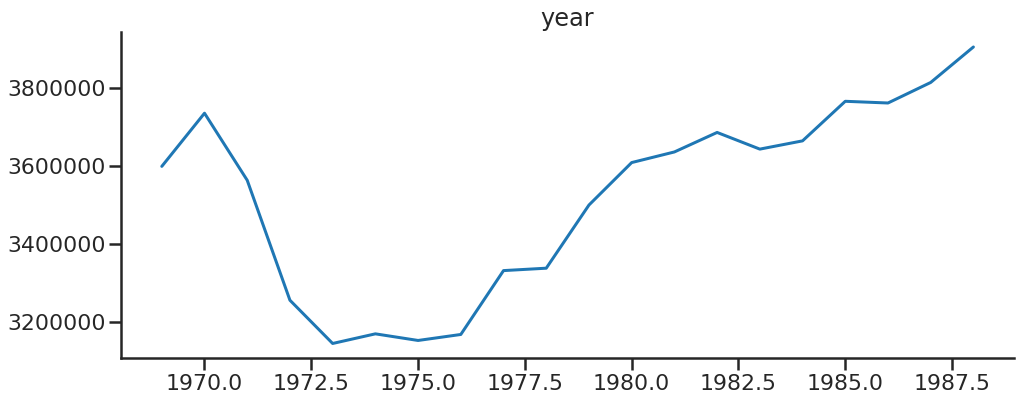

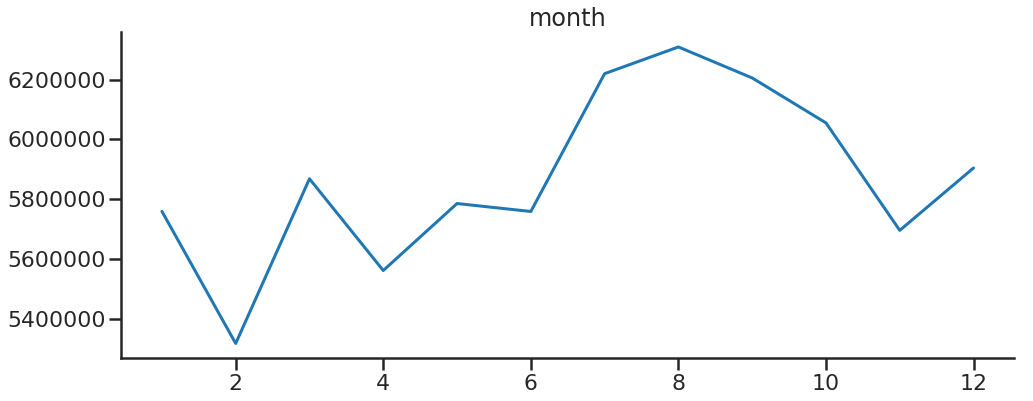

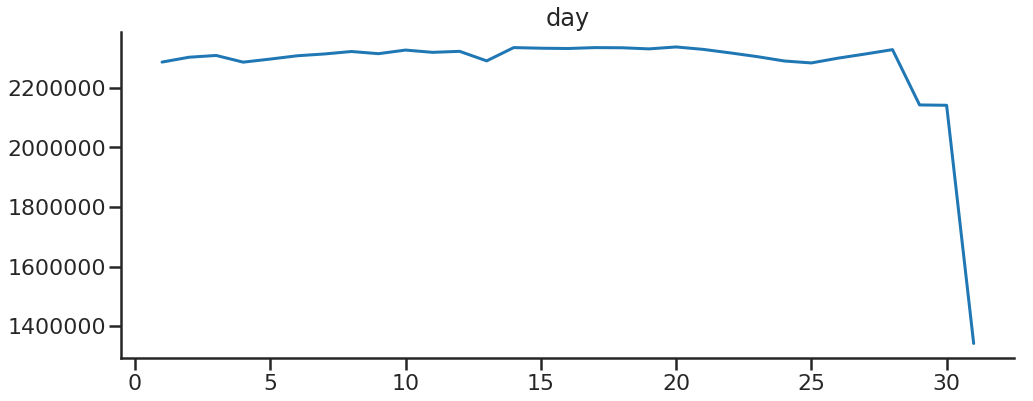

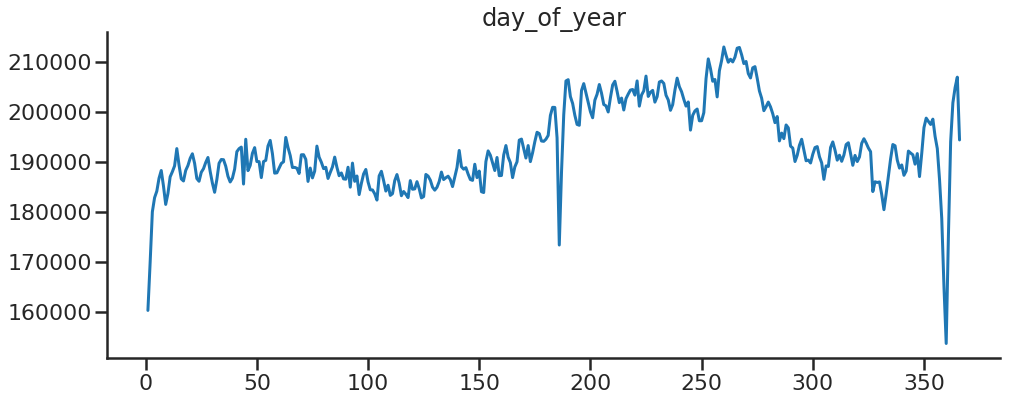

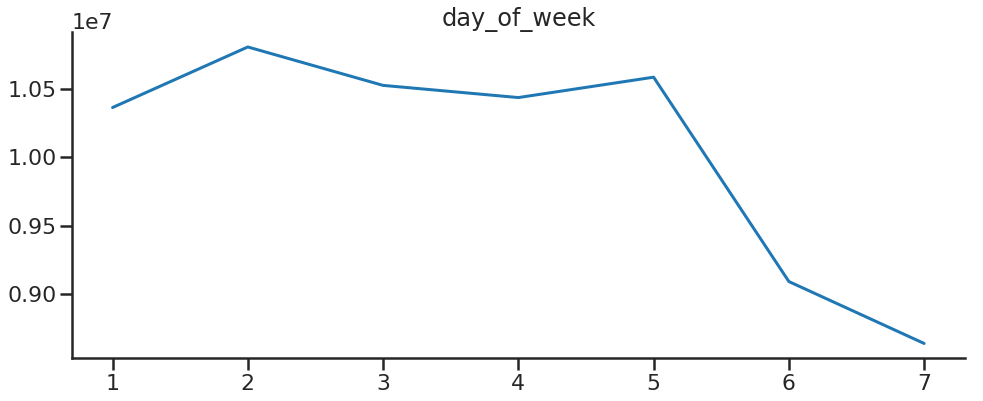

In [8]:
# for every variable except the dependent variable
for col in clean_df.columns.drop('births'):

    # group the sum of births by that variable
    sum_df = clean_df.groupby(col).sum().loc[:, ['births']]

    # show the results
    plt.figure(figsize=(16, 6))
    plt.plot(sum_df)
    plt.title(col)
    sns.despine()
    plt.show()

### distribution of weekdays

In [9]:
def plot_day(day): 
    
    # find entries with specified day of year
    is_day = clean_df.loc[:,'day_of_year']==day
    # filter the table accordingly
    day_df = clean_df[is_day]
    
    # show distribution of weekdays
    sns.distplot(day_df.loc[:, 'day_of_week'], bins=7, kde=False)
    plt.xticks(range(1,8,1),['M','T','W','T','F','S','S'])
    plt.title(day)
    sns.despine(trim=True)
    plt.show()

In [10]:
i = interact(plot_day,day=(1,365))

interactive(children=(IntSlider(value=183, description='day', max=365, min=1), Output()), _dom_classes=('widge…

## transform data

Summarize of 365 days

In [11]:
clean_df.groupby('day_of_year').sum().loc[:,['births']]

,births
day_of_year,
1,160369
2,169896
3,180036
4,182854
5,184145
6,186726
7,188277
8,185186
9,181511


In [12]:
sum_df = clean_df.groupby('day_of_year').sum().loc[:, ['births']]
sum_df.index = pd.date_range('2001-01-01', periods=365, freq='D')

In [13]:
sum_df.tail()

,births
2001-12-27,194006
2001-12-28,201768
2001-12-29,204806
2001-12-30,206894
2001-12-31,194368


### average timecourse over the 365 days

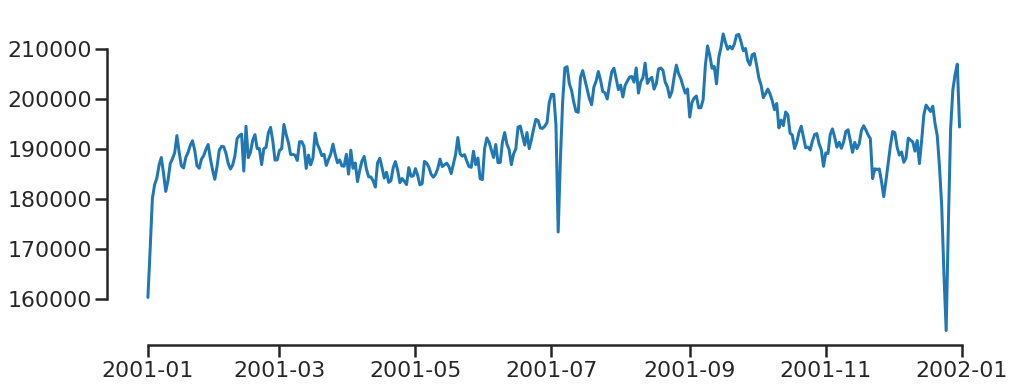

In [14]:
plt.figure(figsize=(16,6))
plt.plot(sum_df)
sns.despine(trim=True)
plt.show()

## model the data

In [15]:
result_decompose = sm.tsa.seasonal_decompose(sum_df,extrapolate_trend=1)

#### the data can be explained by a trend and a high-frequency periodic fluctuation

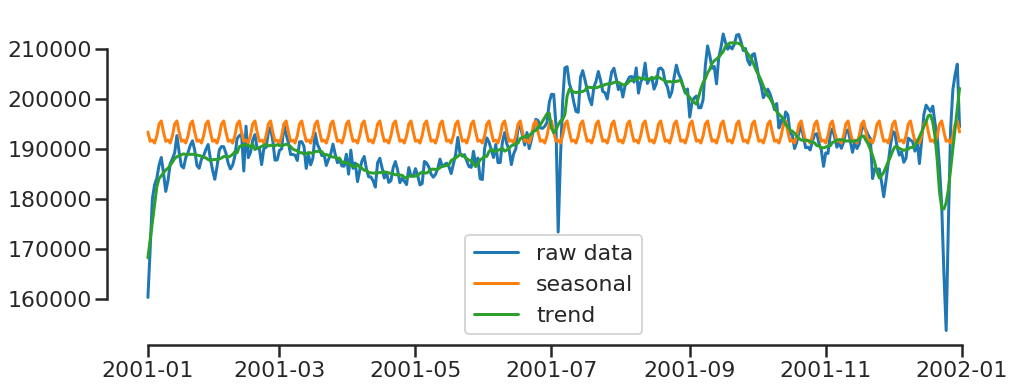

In [16]:
plt.figure(figsize=(16,6))
plt.plot(result_decompose.observed,label='raw data')
plt.plot(result_decompose.seasonal+sum_df.mean(),label='seasonal')
plt.plot(result_decompose.trend,label='trend')
sns.despine(trim=True)
plt.legend(loc='best')
plt.show()

#### if we remove the trend and seasonal predictions, we are left with what is "surprising" about the data

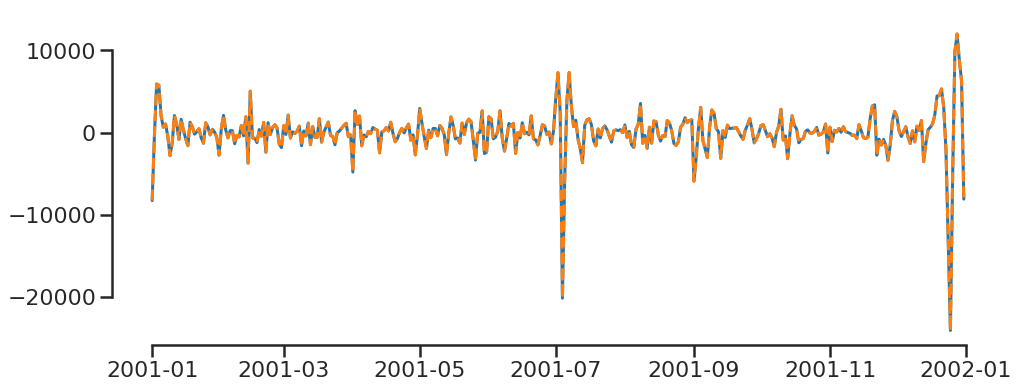

In [17]:
plt.figure(figsize=(16,6))
plt.plot(result_decompose.resid)
plt.plot(result_decompose.observed-result_decompose.seasonal-result_decompose.trend,'--')
sns.despine(trim=True)
plt.show()

## focus on valentine's day

### raw data and predictions

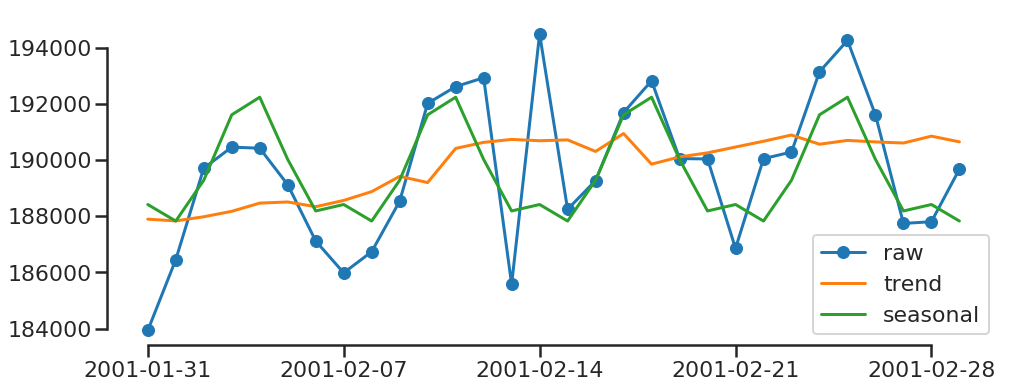

In [18]:
plt.figure(figsize=(16, 6))

plt.plot(
    result_decompose.observed.iloc[30:60], 
    '-o', 
    label='raw')

plt.plot(
    result_decompose.trend.iloc[30:60], 
    '-', 
    label='trend')

plt.plot(
    result_decompose.seasonal.iloc[30:60] +
    result_decompose.observed.iloc[30:60].mean(),
    '-',
    label='seasonal')

plt.legend(loc='best')

sns.despine(trim=True)
plt.show()

#### table of residuals, where the models cannot explain the data

In [19]:
resid_df = result_decompose.resid
resid_df.tail()

,births
2001-12-27,9887.618006
2001-12-28,12005.389984
2001-12-29,8832.087786
2001-12-30,6259.519105
2001-12-31,-8078.746497


### get the date

In [20]:
is_valentine = (resid_df.index == '2001-02-14')
valentines_day = np.where(is_valentine)[0][0]

In [21]:
valentines_day

44

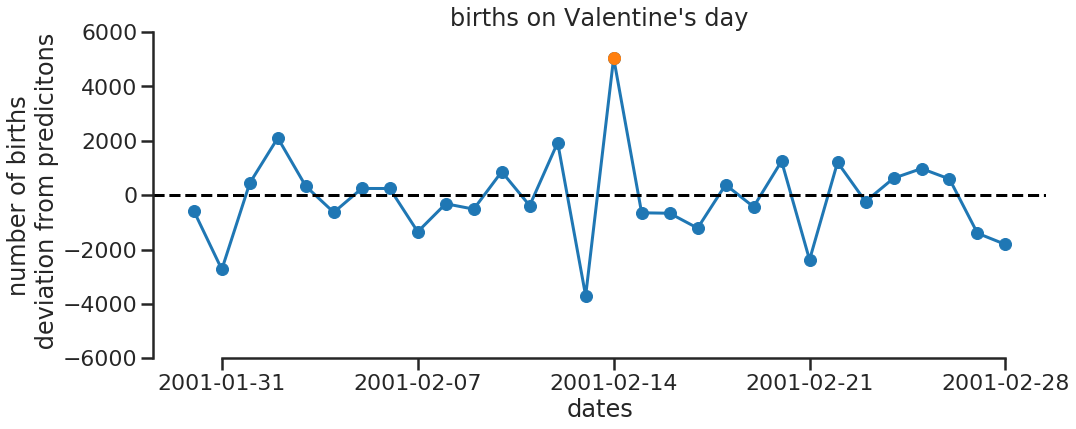

In [22]:
plt.figure(figsize=(16, 6))

plt.plot(resid_df.iloc[valentines_day - 15:valentines_day + 15], '-o')

plt.plot(resid_df.iloc[[valentines_day]], 'o')

plt.ylim(-6000, 6000)
plt.axhline(0, linestyle='--', color='black')

plt.xlabel('dates')
plt.ylabel('number of births\n deviation from predicitons')
plt.title("births on Valentine's day")

sns.despine(trim=True)
plt.show()

## Halloween

In [23]:
is_halloween = (resid_df.index == '2001-10-31')
halloween_day = np.where(is_halloween)[0][0]
halloween_day

303

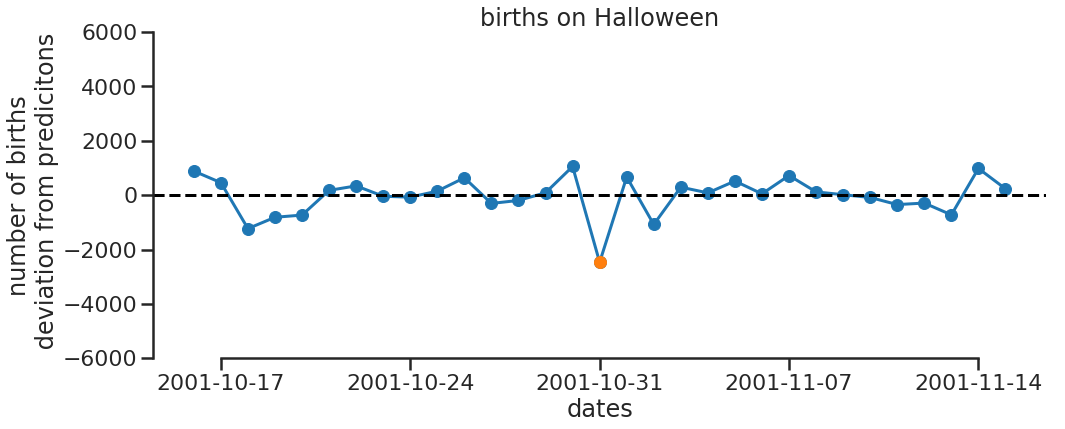

In [24]:
plt.figure(figsize=(16, 6))

plt.plot(resid_df.iloc[halloween_day - 15:halloween_day + 16], '-o')

plt.plot(resid_df.iloc[[halloween_day]], 'o')

plt.ylim(-6000, 6000)
plt.axhline(0, linestyle='--', color='black')

plt.xlabel('dates')
plt.ylabel('number of births\n deviation from predicitons')
plt.title("births on Halloween")

sns.despine(trim=True)
plt.show()

## get deviations from mean

### summary statistics

In [25]:
describe_df = resid_df.describe()
describe_df

,births
count,365.000000
mean,21.299325
std,2701.252240
min,-24049.255620
25%,-705.769357
50%,109.818555
75%,920.376248
max,12005.389984


In [26]:
my_mean = describe_df.loc['mean', 'births']
my_std = describe_df.loc['std', 'births']

my_mean, my_std

(21.299324664562008, 2701.2522403671433)

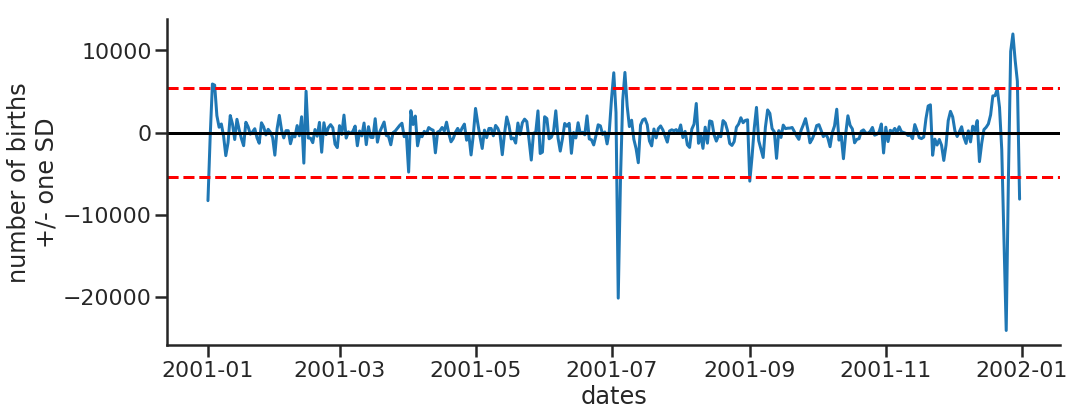

In [27]:
num_std = 2 # how many standard deviations above/below?

plt.figure(figsize=(16, 6))

plt.plot(
    resid_df, 
    '-'
    )

plt.axhline(my_mean,linestyle='-',color='black')
plt.axhline(my_mean+my_std*num_std,linestyle='--',color='r') # mean + SD's
plt.axhline(my_mean-my_std*num_std,linestyle='--',color='r') # mean - SD's

plt.xlabel('dates')
plt.ylabel('number of births\n+/- one SD')

sns.despine()
plt.show()

### get devations through z-transformation  

Advantage: Mean is zero, so we can use the absolute value to get deviations above/below

In [28]:
std_df = pd.DataFrame(
    preprocessing.scale(resid_df),
    index=resid_df.index,
    columns=resid_df.columns)

In [29]:
std_df.tail()

,births
2001-12-27,3.657512
2001-12-28,4.442584
2001-12-29,3.266220
2001-12-30,2.312551
2001-12-31,-3.002742


In [30]:
std_df.describe().round(2)

,births
count,365.00
mean,0.00
std,1.00
min,-8.92
25%,-0.27
50%,0.03
75%,0.33
max,4.44


### select deviations

In [31]:
z_dev = 3 # example, z>3
is_dev = abs(std_df)>z_dev # get absolute deviations
deviation_df = std_df[is_dev].dropna() # get the table

In [32]:
deviation_df

,births
2001-01-01,-3.071270
2001-07-04,-7.465738
2001-12-24,-4.943022
2001-12-25,-8.923119
2001-12-27,3.657512
2001-12-28,4.442584
2001-12-29,3.266220
2001-12-31,-3.002742


### interactive plot

In [33]:
def plot_fig(z_dev):

    # select deviation data
    is_dev = abs(std_df)>z_dev
    deviation_df = std_df[is_dev].dropna()

    plt.figure(figsize=(16, 6))

    # all data
    plt.plot(
        std_df, 
        '-'
        )

    # deviations
    plt.plot(
        deviation_df,
        'o'
        )

    # annotate deviations
    for i in deviation_df.index:
        text = str(i)[5:10]
        value = deviation_df.loc[i,'births']
        plt.annotate(text,xy=(i,value))

    # show z-score cutoffs as lines
    plt.axhline(0,linestyle='-',color='black')
    plt.axhline(z_dev,linestyle='--',color='r')
    plt.axhline(-z_dev,linestyle='--',color='r')

    plt.xlabel('dates')
    plt.ylabel('number of births\n deviation from predicitons')

    sns.despine()
    plt.title('z-score: %.1f'%z_dev)
    plt.show()

In [34]:
i = interact(plot_fig,z_dev=(0,10,0.1))

interactive(children=(FloatSlider(value=5.0, description='z_dev', max=10.0), Output()), _dom_classes=('widget-…